# Algorithms for efficient entropy conversion

By Calum Grant, June 2025

This page is to reproduce the results of the accompanying paper.

The code is in the accompanying [entropy.py](entropy.py) file. We'll import it as follows:

In [1]:
from entropy import *

## Basic operations

The 4 basic operations are provided by `multiply()`, `divide()`, `downsample()` and `upsample()` functions.

In [2]:
multiply(1,6,4,5)

(25, 30)

In [3]:
divide(25,30,6)

(1, 6, 4, 5)

In [4]:
downsample(10,36,3)

(7, 33, False)

In [5]:
upsample(7, 33, 36, False)

(10, 36)

## Distributions

The `entropy` module also defines the distributions `U` and `B`. We can construct `U` objects manually as follows:

In [6]:
U(4,6)

U(6)

The default `U` object has size 1, which means it has no entropy.

In [7]:
U()

U(1)

We can measure the stored entropy using the `entropy()` method:

In [8]:
U().entropy()

0.0

In [9]:
U(1,6).entropy()

2.584962500721156

Whenever you read or consume the entropy, the original entropy becomes empty (`U(1)`). This is to prevent errors reusing the same entropy.

In [10]:
x = U(1,6)
x.entropy()
x.read()

1

Calling `read()` turned `x` into a pumpkin!

In [11]:
x


U(1)

In [12]:
x.entropy()

0.0

The basic entropy operations are implemented on `U`:

In [13]:
U(1,6).multiply(U(2,6))

U(36)

In [14]:
U(10,36).downsample(10)

(U(26), B(10/36))

In [15]:
U(9,36).downsample(10)

(U(10), B(10/36))

The entropy operations *destroy* the original entropy, to prevent errors.

In [16]:
x = U(1,6)
y = x.multiply(U(3,6))
x

U(1)

# Calculating entropy for individual integers

The functions `expected_rejection_sampling()`, `expected_fast_dice_roller()` and `expected_convert()` calculate 
the expected entropy consumption for each integer generated. For example:

In [17]:
expected_rejection_sampling(3), expected_fast_dice_roller(3), worst_case_convert(3)

(2.6666666666666665, 2.6666259765625, 1.5849625300044479)

Interestingly, `worst_case_convert` actually gives a entropy slightly higher for powers of 2, but this is correct.

In [18]:
expected_rejection_sampling(4), expected_fast_dice_roller(4), worst_case_convert(4)

(2.0, 2, 2.0000000431077543)

Let's calculate the entropy efficiency generating the first 52 integers.

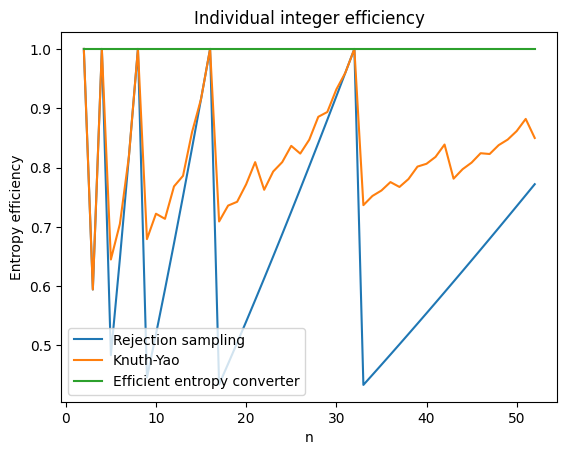

In [34]:
numbers = range(2,53)
rs_efficiency = [math.log2(n)/expected_rejection_sampling(n) for n in numbers]
fdr_efficiency = [math.log2(n)/expected_fast_dice_roller(n) for n in numbers]
eec_efficiency = [math.log2(n)/worst_case_convert(n) for n in numbers]

import matplotlib.pyplot as plt
plt.title('Individual integer efficiency')
plt.xlabel('n')
plt.ylabel('Entropy efficiency')
plt.plot(numbers, rs_efficiency, label='Rejection sampling')
plt.plot(numbers, fdr_efficiency, label='Knuth-Yao')
plt.plot(numbers, eec_efficiency, label='Efficient entropy converter')
plt.legend()
plt.show()

## Calculating entropy of card shuffling


## Simulating card shuffling


### Rejection sampling

We'll create a binary entropy store which reads hardware entropy one bit at a time, returning `U(2)` each time

In [ ]:
bin = BinaryEntropySource()
bin.get(2)

U(2)

`MeasuringStore` wraps any store and keeps track of how much entropy was delivered.

In [ ]:
measured_input = MeasuringStore(bin)

In [ ]:
measured_input.reset()
measured_input.get(2)
measured_input.get(2)
measured_input.entropy

2.0

Set up an entropy store based on rejection sampling and measure its outputs:

In [ ]:
rs = RejectionSamplingEntropySource(measured_input)
measured_output = MeasuringStore(rs)

Perform the shuffling and gather the data:

In [ ]:
measured_input.reset()
measured_output.reset()
rs.expected_entropy_in = 0
shuffle(deck(), measured_output) 

Let's see how much entropy was (a) actually output, (b) input, (c) expected input

In [ ]:
measured_output.entropy, measured_input.entropy, rs.expected_entropy_in

(225.58100312370277, 365.0, 355.90835089243757)

Actually, we are more interested in the *theoretical* expected input entropy, which we can calculate precisely rather than running lots of trials. The measured output entropy is always the same.

The theoretical efficiency of Von Neumann rejection sampling is given by

In [ ]:
measured_output.entropy / rs.expected_entropy_in

0.6338176740109078

### Fast Dice Roller

The FDR should be the same as Knuth-Yao, but FDR is much simpler to implement.

Let's repeat the measurement for FDR.

Firstly, how can we calculate the expected entropy consumption (and therefore efficiency) for a single random integer. Of course, this depends on the number generated.

In [ ]:
expected_rejection_sampling(6), expected_fast_dice_roller(6), worst_case_convert(6)

(4.0, 3.6666259765625, 2.584962570851532)

Interestingly, EEC does worse on powers of 2

In [ ]:
expected_rejection_sampling(8), expected_fast_dice_roller(8), worst_case_convert(8)

(3.0, 3, 3.0000000966002145)